# Actividad 1: Corrección de anomalías

En esta actividad vamos a tratar de corregir el artefacto de ruido conocido como 'Salt & Pepper'. En la primera parte, explicaremos cómo funciona y lo aplicaremos sobre una imagen contaminada, donde veremos qué implicaciones tiene en el resultado a través de su histograma o de la entropía obtenida.

En la segunda parte iremos un paso más alla y realizaremos el preprocesado de un vídeo, en el que corregiremos el problema frame a frame, y obtendremos un resultado sin ruido.

## 1ª Parte. Corrección de ruido impulsivo en imágenes
### Importación de librerías de uso genérico para nuestro propósito

In [1]:
# from scipy import misc,ndimage # No se han utilizado
import numpy as np               # trabajo con arrays
import matplotlib.pyplot as plt  # gráficos
import imageio                   # manejo de imágenes

### Definición de Funciones

In [2]:
from tqdm.notebook import tqdm   # barra de porcentaje para tareas

def add_noise(img):
    """
        Esta función recibe una imagen y genera ruido de tipo sal y pimienta. Elige píxeles de forma aleatoria y 
        los pinta de color blanco para el caso de la sal o de color negro en el caso de la pimienta.

        Parámetros:
            img -- array que contiene los datos de la imagen sobre la que se generará ruido
    """
    # copiamos la imagen para no modificar la original en lo que será la salida de nuestra función
    out = np.copy(img)

    # Obtenemos las dimensiones de la imágen 
    row, col, ch = img.shape 
    
    salt_noise = 0.6 #el 60% del ruido que generemos será sal (blanco)
    pepper_noise = (1. - salt_noise)
    amount_noise = 0.2 # cantidad de ruido a aportar por cada artefacto introducido
      
    number_of_salt_pixels = int(amount_noise * img.size * salt_noise)
    number_of_pepper_pixels = int(amount_noise * img.size * pepper_noise)
   
    with tqdm(total=number_of_salt_pixels + number_of_pepper_pixels) as pbar:
        pbar.set_description('Generando sal y pimienta')
        
        # generamos la sal
        for i in range(number_of_salt_pixels): 
            y_coord=np.random.randint(0, row - 1) 
            x_coord=np.random.randint(0, col - 1) 
            # Pintamos el pixel de blanco (sal)
            out[y_coord][x_coord] = 255
            pbar.update(1)

        # generamos la pimienta
        for i in range(number_of_pepper_pixels): 
            y_coord=np.random.randint(0, row - 1) 
            x_coord=np.random.randint(0, col - 1) 
            # pintamos el pixel de negro (pimienta)
            out[y_coord][x_coord] = 0
            pbar.update(1)
          
    return out

In [3]:
# El filtro de mediana lo utilizaremos para eliminar el ruido de la imagen en cada uno de los canales
def median_filter(data, filter_size):
    temp = []
    indexer = filter_size // 2
    data_final = np.zeros((len(data),len(data[0])))
    for i in range(len(data)):

        for j in range(len(data[0])):

            for z in range(filter_size):
                if i + z - indexer < 0 or i + z - indexer > len(data) - 1:
                    for c in range(filter_size):
                        temp.append(0)
                else:
                    if j + z - indexer < 0 or j + indexer > len(data[0]) - 1:
                        temp.append(0)
                    else:
                        for k in range(filter_size):
                            temp.append(data[i + z - indexer][j + k - indexer])

            temp.sort()
            data_final[i][j] = temp[len(temp) // 2]
            temp = []
    return data_final

In [4]:
from numba import njit,prange

@njit(parallel=True)
def adaptative_median_filter(img, size=3, size_max=7):
    if len(img.shape) > 2:
        raise Exception('Only single channels can be filtered. Call this method n times if you have a multichannel image')

    height, width = img.shape
    indexer = size_max//2
    
    padded_img = np.zeros((img.shape[0] + 2*indexer, img.shape[1] + 2*indexer))
    padded_img[indexer:-indexer,indexer:-indexer] = img

    # creamos lo que será la imagen filtrada, del mismo tamaño que la original
    filtered_img = np.zeros(padded_img.shape)

    # Utilizamos prange para poder paralelizar las iteraciones y aumentar el rendimiento del algoritmo
    for x in prange(indexer, height + indexer + 1):
        for y in range(indexer, width + indexer + 1):
            value = Lvl_A(padded_img, x, y, size, size_max)
            filtered_img[x,y] = value

    return filtered_img[indexer:-indexer,indexer:-indexer]

@njit
def Lvl_A(padded_img, x, y, size, size_max):
    
    window = padded_img[x-(size//2):x+(size//2)+1,y-(size//2):y+(size//2)+1]
    
    min_val = np.min(window)
    med_val = np.median(window)
    max_val = np.max(window)
   
    if min_val < med_val < max_val:   
        return Lvl_B(window, min_val, med_val, max_val)
    else:
        # aumentamos tamaño de ventana
        size += 2 
        if size <= size_max:
            return Lvl_A(padded_img,x,y,size,size_max)
        else:
            return med_val

@njit
def Lvl_B(window, min_val, med_val, max_val):
    heigth, width = window.shape

    min_val = np.min(window)
    med_val = np.median(window)
    max_val = np.max(window)
    
    # miramos el pixel a filtrar (centro de la ventana)
    val_xy = window[heigth//2, width//2]

    if min_val < val_xy < max_val:
        return val_xy
    else:
        return med_val

def filter_image(channels, window_size):
    """
        Esta función es la encargada de aplicar el filtro de mediana estándar en la imagen
        Itera sobre los canales de la imagen y realiza el filtrado de forma independiente, aplicando 
        una ventana del tamaño que se le indique.

        Dependiendo del tamaño de la imagen que queramos filtrar y el tamaño de la ventana
        seleccionado, podrá tardar varios segundos. Muestra una barra de progreso para
        indicar que todo se esté realizando correctamente.

        Devuelve un array con los canales filtrados.

        Parámetros:
            channels        -- array que contendrá los tres canales de la imagen RGB
            window_size     -- tamaño de la ventana a aplicar en el filtro de mediana adaptativo inicial
    """
    fixed_rgb_info = []
    with tqdm(total=len(channels)) as pbar:
        for index, channel in enumerate(channels): 
            pbar.set_description('Processing image with median filter')
            fixed_channel = median_filter(channel, window_size)
            fixed_rgb_info.append(fixed_channel)
            pbar.set_postfix({'CHANNELS PROCESSED': index + 1})
            pbar.update(1)
        return fixed_rgb_info

    
def filter_image_adaptative(channels, window_size, window_size_max):
    """
        Esta función es la encargada de aplicar el filtro de mediana adaptativo en la imagen
        Itera sobre los canales de la imagen y realiza el filtrado de forma independiente, aplicando 
        una ventana del tamaño que se le indique.
        
        Dependiendo del tamaño de la imagen que queramos filtrar y el tamaño de la ventana
        seleccionado, podrá tardar varios segundos. Muestra una barra de progreso para
        indicar que todo se esté realizando correctamente.
        
        Devuelve un array con los canales filtrados.

        Parámetros:
            channels        -- array que contendrá los tres canales de la imagen RGB
            window_size     -- tamaño de la ventana a aplicar en el filtro de mediana adaptativo inicial
            window_size_max -- tamaño máximo que se aplicará sobre la ventana para el filtrado
    """
    fixed_rgb_info = []
    with tqdm(total=len(channels)) as pbar:
        for index, channel in enumerate(channels): 
            pbar.set_description('Processing image with adaptative median filter')
            fixed_channel = adaptative_median_filter(channel, window_size, window_size_max)
            fixed_rgb_info.append(fixed_channel)
            pbar.set_postfix({'CHANNELS PROCESSED': index + 1})
            pbar.update(1)
        return fixed_rgb_info

### Carga de Datos de Imagen

tenemos una imagen de:  (614, 959, 3)


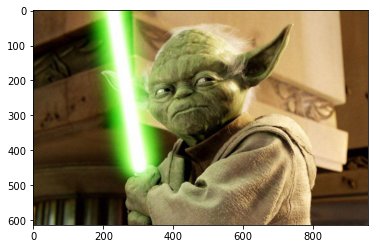

In [5]:
yoda = imageio.imread('imagenes/yoda.png')# la imagen se convierte a NumPy array
plt.imshow(yoda) #comprobamos que la imagen cargada es correcta
print("tenemos una imagen de: ",yoda.shape)

### Procesado de imágenes ruidosas (*noisy*)

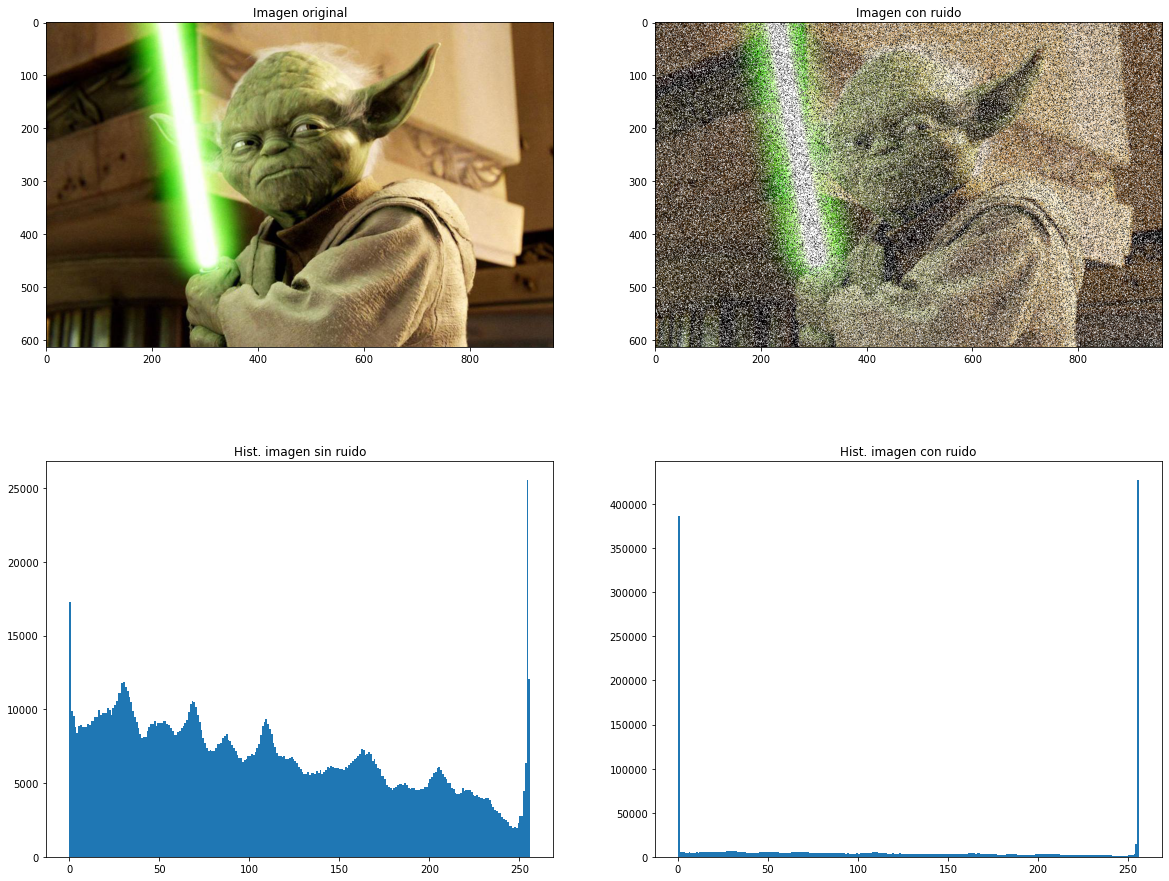

In [6]:
# Aplicamos el ruido 'salt & pepper' con nuestra función sobre la imagen cargada
im_add_noise = add_noise(yoda)

f, axs = plt.subplots(1,2,figsize=(20,16))

plt.subplot(2, 2, 1)  #Primera posición del subplot
plt.imshow(yoda)
plt.title('Imagen original')

plt.subplot(2, 2, 2)  #Segunda posición del subplot
plt.imshow(im_add_noise)
plt.title('Imagen con ruido')

plt.subplot(2, 2, 3)  #Tercera posición del subplot
plt.title('Hist. imagen sin ruido')
plt.hist(yoda.ravel(),256,[0,256]);

plt.subplot(2, 2, 4)  #Cuarta posición del subplot
plt.title('Hist. imagen con ruido')
plt.hist(im_add_noise.ravel(),256,[0,256]);
plt.show()

De las figuras anteriores podemos sacar principalmente dos conclusiones:
1. Tenemos una imagen original con un alto rango dinámico que abarca todo el rango del histograma (0 a 255).
2. En la imágen con ruido de tipo impulsivo, las muestras con valor 0 y 255 aumentan en función de la cantidad existente de ruido de ambos tipos. El ruido de máxima intensidad (valor = 255) es de tipo *salt*, mientras que el ruido conocido como *peper* tiene un valor de intensidad igual a 0.

Nos podemos centrar en una parte de la imagen para observar con más detalle el ruido aplicado

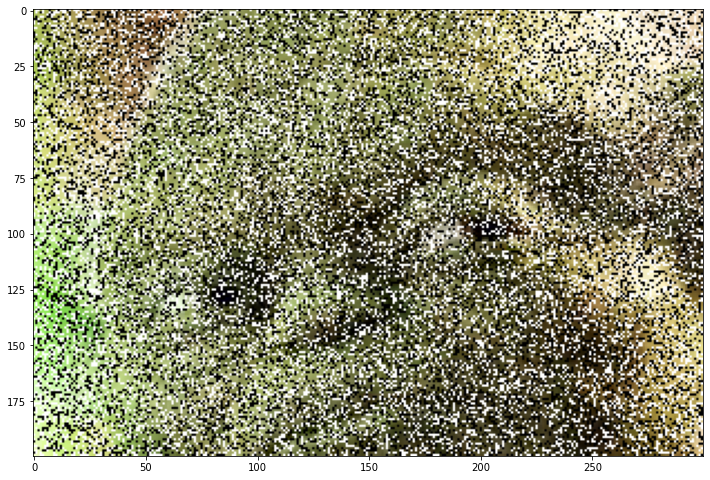

In [7]:
im_add_noise_face = im_add_noise[100:300, 300:600, :]
plt.figure(figsize = (12,12))
plt.imshow(im_add_noise_face, cmap=plt.cm.gray)

Utilizaremos un filtro de mediana que recorrerá la imagen para corregir el valor de los píxeles anómalos. Este filtro es ideal para eliminar el ruido aleatorio impulsivo unipolar o bipolar, como es, este último, el caso del ruido llamado "sal y pimienta". Por contra se pierde contraste de la imagen por el propio trabajo del filtro, y en caso de no escoger un buen valor del tamaño de la ventana del *kernel*, este efecto se agudizará, o por contra no eliminará el ruido.

El filtro de mediana reemplaza cada píxel con la mediana de los niveles de intensidad de sus vecinos. Por ejemplo, si tenemos un filtro con una ventana 3x3, y con los siguientes 9 valores, ya ordenados, 5, 10, 15, 16, 30, 34 y 39, nuestro filtro, para el cálculo de la mediana, tomará el valor que deja a ambos lados la mitad de las muestras; en el ejemplo anterior es 16 el valor de salida, o el valor que tomará ese pixel central sobre el que se le ha aplicado el filtro.

El filtro implementado es un filtro bidimensional, que recorrerá la imagen a lo largo y ancho, luego para aplicarlo debemos convertir la imagen a un formato bidimensional. Para ello se decodifcia la imagen en cada uno de los canales RGB:

Text(0.5, 1.0, 'canal azul')

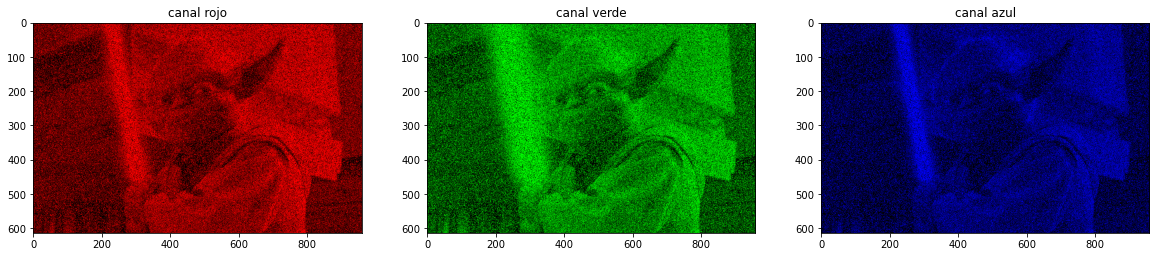

In [8]:
# separamos la imagen en canales RGB

# Rojo
im_red_noise=np.copy(im_add_noise)
im_red_noise[:,:,1]=0
im_red_noise[:,:,2]=0

# Verde
im_green_noise=np.copy(im_add_noise)
im_green_noise[:,:,0]=0
im_green_noise[:,:,2]=0

# Azul
im_blue_noise=np.copy(im_add_noise)
im_blue_noise[:,:,0]=0
im_blue_noise[:,:,1]=0

# Comprobamos las imágenes
f, axs = plt.subplots(figsize=(20,14))
plt.subplot(1, 3, 1) 
plt.imshow(im_red_noise)
plt.title('canal rojo')
plt.subplot(1, 3, 2)  
plt.imshow(im_green_noise)
plt.title('canal verde')
plt.subplot(1, 3, 3)  
plt.imshow(im_blue_noise)
plt.title('canal azul')

Aplicamos el filtrado utilizando la función propia **filter_image()** y mostramos los resultados. 

**AVISO:** 
La ejecución de este fragmento de código puede tardar varios segundos (< 20s)

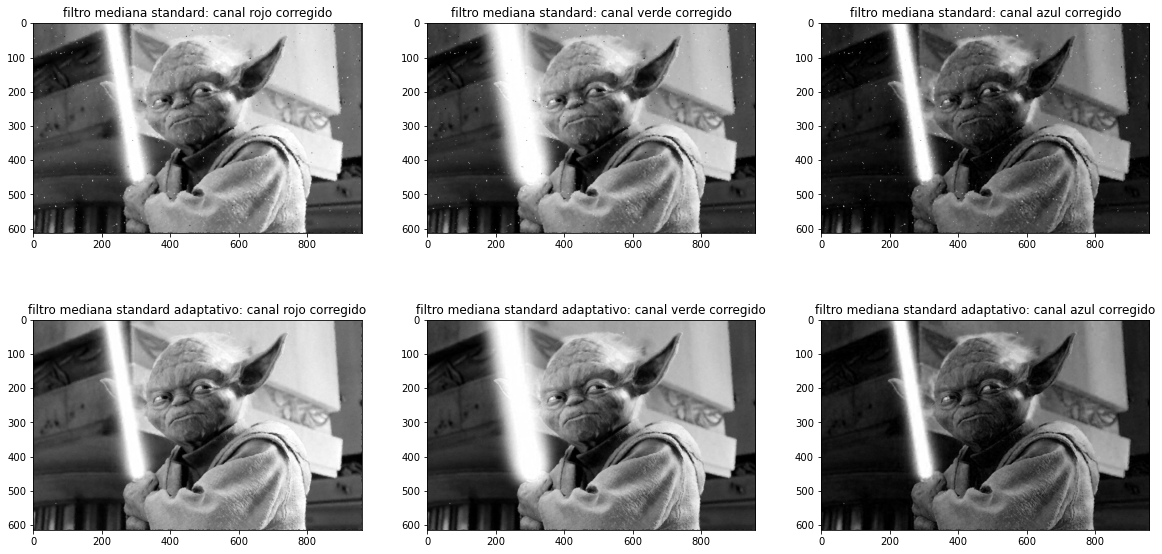

In [9]:
yoda_noise_rgb_channels = [im_red_noise[..., 0], im_green_noise[..., 1], im_blue_noise[..., 2]]

yoda_fixed_rgb_info = filter_image(yoda_noise_rgb_channels, 5)
yoda_fixed_rgb_info_adaptative = filter_image_adaptative(yoda_noise_rgb_channels, 5, 7)

# Mostramos las imágenes

# standard median filter results
f, axs = plt.subplots(figsize=(20,10))
plt.subplot(2, 3, 1)
plt.title('filtro mediana standard: canal rojo corregido')
plt.imshow(yoda_fixed_rgb_info[0], cmap="gray")
plt.subplot(2, 3, 2)  
plt.title('filtro mediana standard: canal verde corregido')
plt.imshow(yoda_fixed_rgb_info[1], cmap="gray")
plt.subplot(2, 3, 3)  
plt.title('filtro mediana standard: canal azul corregido')
plt.imshow(yoda_fixed_rgb_info[2], cmap="gray")
# adaptative median filter results
plt.subplot(2, 3, 4)
plt.title('filtro mediana standard adaptativo: canal rojo corregido')
plt.imshow(yoda_fixed_rgb_info_adaptative[0], cmap="gray")
plt.subplot(2, 3, 5)  
plt.title('filtro mediana standard adaptativo: canal verde corregido')
plt.imshow(yoda_fixed_rgb_info_adaptative[1], cmap="gray")
plt.subplot(2, 3, 6)  
plt.title('filtro mediana standard adaptativo: canal azul corregido')
plt.imshow(yoda_fixed_rgb_info_adaptative[2], cmap="gray")

En el bloque de figuras anterior se pueden observar los tres canales en escala de grises de la salida de cada uno de los filtros aplicados, filtro de mediana estándar y filtro de mediana adaptativo.

Una primera conclusión, en línea con la propia definición del filtro, es que es capaz de manejar mayor cantidad de ruido que el de mediana estándar, ya que este último no ha eliminado el ruido impulsivo por completo de la imágen.

En las siguientes figuras se puede observar la salida real a color de ambos filtros, donde se observa, con mayor claridad, ciertos problemas con el ruido impulsivo de alta densidad para el caso del filtro de mediana estándar:

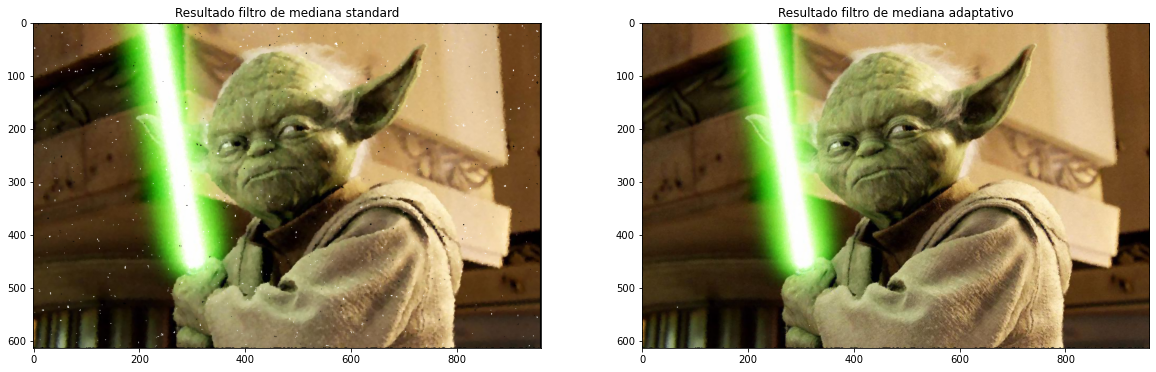

In [10]:
# Copiamos la información 'corregida' a los canales originales, ya que ellos poseen la información del color

# reconstruimos la imagen a partir de los resultados del filtro de mediana standard
yoda_reconstruido = np.zeros((yoda.shape[0], yoda.shape[1], 3), 'uint8')
yoda_reconstruido[..., 0] = yoda_fixed_rgb_info[0]
yoda_reconstruido[..., 1] = yoda_fixed_rgb_info[1]
yoda_reconstruido[..., 2] = yoda_fixed_rgb_info[2]

# reconstruimos la imagen a partir de los resultados del filtro de mediana adaptativo
yoda_reconstruido_adaptative = np.zeros((yoda.shape[0], yoda.shape[1], 3), 'uint8')
yoda_reconstruido_adaptative[..., 0] = yoda_fixed_rgb_info_adaptative[0]
yoda_reconstruido_adaptative[..., 1] = yoda_fixed_rgb_info_adaptative[1]
yoda_reconstruido_adaptative[..., 2] = yoda_fixed_rgb_info_adaptative[2]

f, axs = plt.subplots(figsize=(20,10))
plt.subplot(1, 2, 1)
plt.title('Resultado filtro de mediana standard')
plt.imshow(yoda_reconstruido, cmap="gray")

plt.subplot(1, 2, 2)
plt.title('Resultado filtro de mediana adaptativo')
plt.imshow(yoda_reconstruido_adaptative, cmap="gray")

### Presentación de resultados
El filtro de mediana adaptativo, generalmente, obtiene resultados mejores que el filtro de mediana con ventana fija. Es capaz de manejar mayor densidad de ruido impulsivo, suaviza otro tipo de ruido no-impulsivo, y además reduce la distorsión de bordes anchos o estrechos de los objetos.

El filtro de mediana adaptativo opera sobre una ventana cuadrada $S_{xy}$, que varía, aumenta, en función de ciertas condiciones que se verán a continuación. Matemáticamente se denota como:
\begin{equation*}
  \hat{f}(x,y) = \underset{(s,t)\in S_{xy}}{\mathrm{median}} \{g(s,t)\}
\end{equation*}

La notación empleada para la formulación del filtro en nuestro algoritmo es la siguiente:
- $S_{xy}$ = ventana o *kernel* activo del filtro con centro en xy.
- $S_{max}$ = tamaño máximo de ventana definido por el usuario.
- $z_{min}$ = valor mínimo de intensidad en $S_{xy}$.
- $z_{max}$ = valor máximo de intensidad en $S_{xy}$.
- $z_{med}$ = mediana de los valores de intensiad de $S_{xy}$.
- $z_{xy}$ = valor de intensidad de las coordenadas (x,y)

$S_{xy}$ y $S_{max}$ son impares > 1, para que la ventana tenga un centro (x,y), que es el pixel a tratar.

El algoritmo para el filtro de mediana adaptativo utiliza dos niveles de procesamiento, nivel A y nivel B, para cada coordenada (x,y):
- Nivel A: 

  Si $z_{min}$ < $z_{med}$ < $z_{max}$, salta al nivel B

  si_no, aumenta el tamaño de la ventana $S_{xy}$

  Si $S_{xy}$ <= $S_{max}$, salta al inicio del Nivel_A

  si_no, output = $z_{med}$ // *output* = $z_{xy}$ 

- Nivel B:

  Si $z_{min}$ < $z_{xy}$ < z_{max}, *output* = $z_{xy}$

  si_no output = $z_{med}$

En el último paso del nivel A existen dos variantes, una que devuelve la mediana, como es nuestro caso, y otra que no varía el valor del pixel tartado (x,y). Esta útlima opción, como parece lógico trata mejor la imagen, pero puede no detectar el ruido impulsivo sobre un fondo constante dentro de los intervalos chequeados.

Siguiendo con el nivel A, su misión es la de detectar si su salida 'zmed' es un impulso o no, en este sentido si la condición $z_{min}$ < $z_{med}$ < $z_{max}$ es 'TRUE', entonces zmed no puede ser un impulso y salta al nivel B. En el nivel B se testea si esa coordenada (x,y) es en sí misma un impulso. Si su propia intensidad ($z_{xy}$) está dentro del intervalo (zmin, zmax), (x,y) no es un impulso y devuelve su valor sin modificar. Este tratamiento es el que permite reducir la distorsión en la imagen filtrada. Si por el contrario $z_{xy}=z_{min}$, o $z_{xy}=z_{max}$, en ambos casos (x,y) es un impulso y se modifica su valor por la mediana de la ventana, valor de mediana que sabemos que no es ruido impulsivo porque ante ha pasado el nivel A. Esto último también lo hace el filtro de mediana estándar, solo que este filtro lo hace para cada punto, lo que provoca una pérdida de contraste y detalle.

Por otro lado, supongamos qie el nivel A trata un impulso, y por tanto no pasa al nivel B. Entonces, el algoritmo incrementa la ventana (en 2 unidades) y repite el inicio del bucle del nivel A, hasta que se encuentra un valor de mediana que no es un impulso, y salta al nivel B, o hasta que se alcanza el tamaño máximo de ventana. Esta salida no es, en sí misma, definitoria de que no se trate de ruido el pixel tratado; para evitar esto Smax debe ser suficiente.

Por último, decir que en cada iteración del algoritmo, para diferentes (x,y), el tamaño de la ventana se restablece para aligerear la carga computacional, así como para obtener mejores resultados, ya que con un aumento constante de la ventana, el problema se volvería intratable dimensionalmente.   


Para tratar los resultados a un mayor nivel de detalle es necesario observar en primer lugar las imágenes con sus histogramas correspondientes para poder ver el rango dinámico de las imágenes, y cómo les ha podido influir el ruido, o las correcciones hechas sobre ellas.

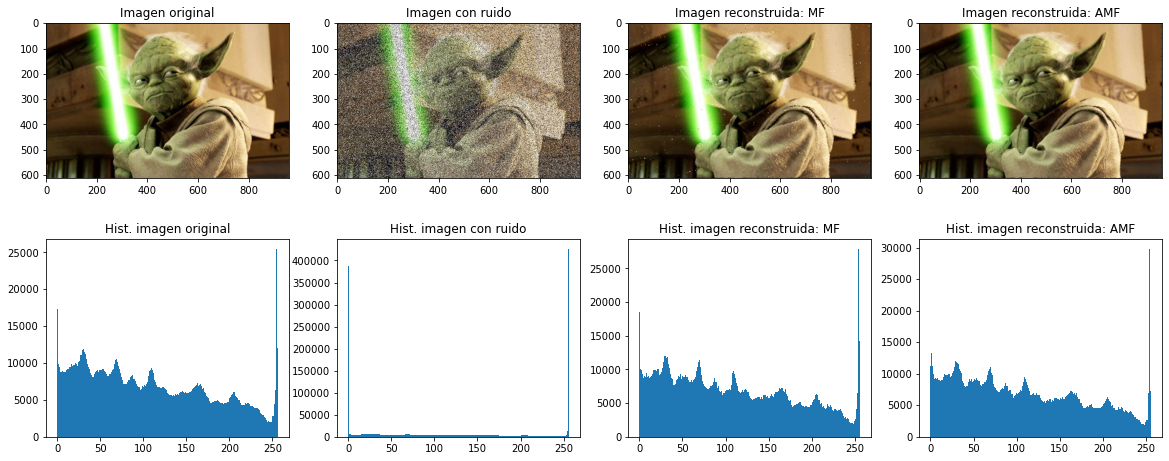

In [11]:
f, axs = plt.subplots(figsize=(20,8))
plt.subplot(2, 4, 1) 
plt.imshow(yoda)
plt.title('Imagen original')
plt.subplot(2, 4, 5) 
plt.title('Hist. imagen original')
plt.hist(yoda.ravel(),256,[0,256]);

plt.subplot(2, 4, 2)  
plt.imshow(im_add_noise)
plt.title('Imagen con ruido')
plt.subplot(2, 4, 6) 
plt.title('Hist. imagen con ruido')
plt.hist(im_add_noise.ravel(),256,[0,256]);

plt.subplot(2, 4, 3)  
plt.imshow(yoda_reconstruido)
plt.title('Imagen reconstruida: MF')
plt.subplot(2, 4, 7) 
plt.title('Hist. imagen reconstruida: MF')
plt.hist(yoda_reconstruido.ravel(),256,[0,256]);

plt.subplot(2, 4, 4)  
plt.imshow(yoda_reconstruido_adaptative)
plt.title('Imagen reconstruida: AMF')
plt.subplot(2, 4, 8) 
plt.title('Hist. imagen reconstruida: AMF')
plt.hist(yoda_reconstruido_adaptative.ravel(),256,[0,256]);

En segundo lugar, el estudio de las entropías nos aportará una valiosa información para corroborar los 3 aspectos sobre los que trabaja el filtro de mediana adaptativo, y cómo mejora los resultados sobre el de mediana estándar.

/opt/anaconda3/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3418: UserWarning: Possible precision loss converting image of type float64 to uint8 as required by rank filters. Convert manually using skimage.util.img_as_ubyte to silence this warning.
  exec(code_obj, self.user_global_ns, self.user_ns)


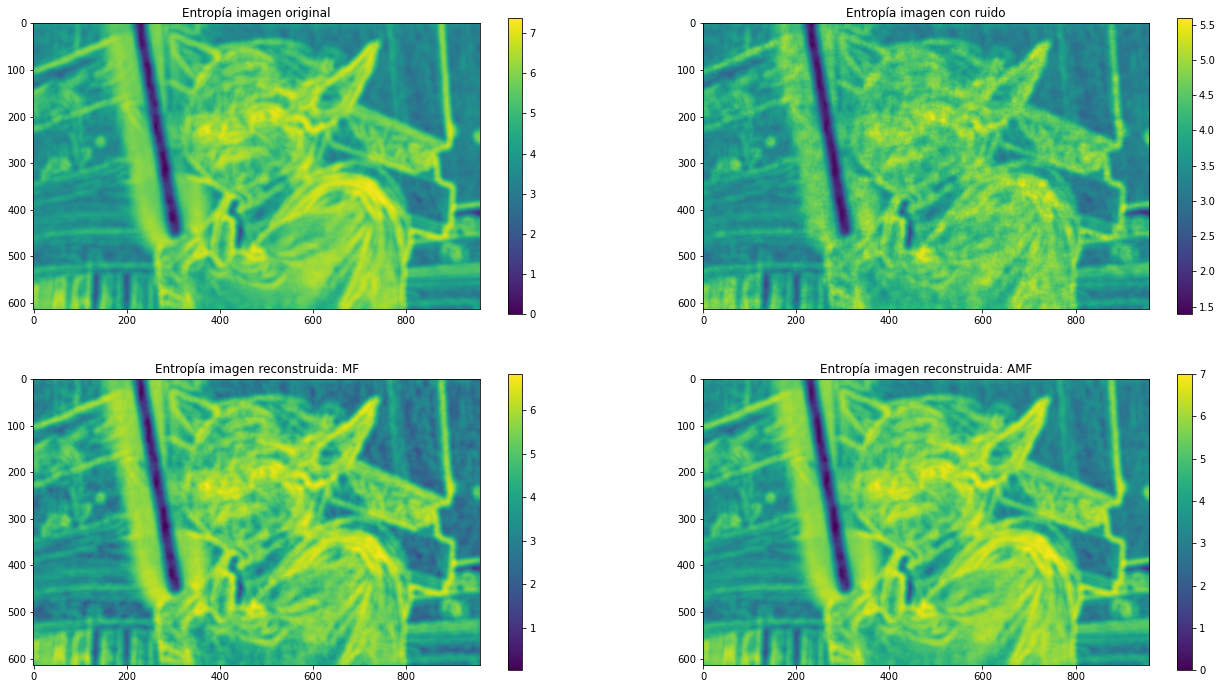

In [12]:
from skimage.filters.rank import entropy
from skimage.morphology import disk
from skimage import color

entropy_yoda_img = entropy(color.rgb2gray(yoda), disk(10))
entropy_yoda_noise_img = entropy(color.rgb2gray(im_add_noise), disk(10))
entropy_yoda_reconstruido_img = entropy(color.rgb2gray(yoda_reconstruido), disk(10))
entropy_yoda_reconstruido_adaptative_img = entropy(color.rgb2gray(yoda_reconstruido_adaptative), disk(10))


f, axs = plt.subplots(figsize=(22,12))
plt.subplot(2, 2, 1) 
plt.imshow(entropy_yoda_img, cmap="viridis")
plt.title('Entropía imagen original')
plt.colorbar()
plt.subplot(2, 2, 2)  
plt.imshow(entropy_yoda_noise_img, cmap="viridis")
plt.title('Entropía imagen con ruido')
plt.colorbar()
plt.subplot(2, 2, 3)  
plt.imshow(entropy_yoda_reconstruido_img, cmap="viridis")
plt.title('Entropía imagen reconstruida: MF')
plt.colorbar()
plt.subplot(2, 2, 4)
plt.imshow(entropy_yoda_reconstruido_adaptative_img, cmap="viridis")
plt.title('Entropía imagen reconstruida: AMF')
plt.colorbar()

Para representar la entropía de los diferentes píxeles de las imágenes, hemos hecho uso de la función *entropy*, de la librería *skimage*. Esta función representa las variaciones de los píxeles dentro de un vecindario de forma circular y radio *disk*. Como se puede observar en los resultados anteriores, a mayor diversidad/complejidad de los pixeles dentro de un vecindario, la entropía aumenta.

Esto extrapolado a nuestras imágenes nos dice que a mayor entropía, mayor resolución y definición.

Esto adquiere todo el sentido, ya que para la imagen con ruido, la entropía alcanza valores máximos de 5.5 y parte de 1.5, y no de 0, debido a la gran densidad de ruido que impide tener un vecindario constante de intensidad de color. A partir de esta imagen, la entropía se ensancha hasta aproximadamente los 7 puntos para la imagen reconstruida con el filtro de mediana tradicional, pero esta vez desde 0 por la acción del filtro, sobre todo en la parte de la espada láser. Pero la conclusión de mayor valor del análisis que se puede sacar de las imágenes anteriores, es que la imagen filtrada con el filtro de mediana adaptativo, todavía tiene mayor entropía, mayor contraste, y menor distorsión en los bordes que la imagen original. Esto se debe a los tres campos donde el filtro trabaja, eliminando ruido impulsivo, suavizando otros tipo de ruido, y aportando contraste en las fronteras de los objetos.

## 2ª Parte. Corrección de ruido impulsivo en video

A continuación, expandiremos la técnica aplicada en el apartado anterior para corregir un vídeo que presenta muestras de ruido. Trataremos el vídeo como una serie de fotogramas sobre los cuales aplicaremos el filtrado para corregir el problema.

Puede ser necesario instalar en el sistema *ffmpeg* para que las librerías de video funcionen:

`conda install -c menpo ffmpeg`

In [14]:
print("Abriendo video...")
original_video= 'videos/corto2_640x480.mp4' #video 1
#original_video= 'videos/corto640x480.mp4' #video alternativo
video_reader = imageio.get_reader(original_video)

# Podemos observar los metadatos que contiene nuestro vídeo de la siguiente manera
metadata = video_reader.get_meta_data()

import json # Importamos la libería json para poder hacer un 'prettify' de los metadatos
print(json.dumps(metadata, indent=2))

Abriendo video...
{
  "plugin": "ffmpeg",
  "nframes": Infinity,
  "ffmpeg_version": "4.2.2 built with Apple clang version 11.0.0 (clang-1100.0.33.8)",
  "codec": "h264",
  "pix_fmt": "yuv420p",
  "fps": 29.97,
  "source_size": [
    640,
    480
  ],
  "size": [
    640,
    480
  ],
  "duration": 3.54
}


Para poder trabajar con el vídeo, lo convertiremos a un arreglo de numpy

In [15]:
cant_frames= video_reader.count_frames()
video_resolution = metadata['source_size']

print ("nº de frames = ",cant_frames,"a resolución: ",video_resolution)

dimensiones = (cant_frames, video_resolution[1], video_resolution[0], 3)

# se crea un arreglo numpy de 4 dimensiones (nframes, filas, columnas, 3)
video_np= np.zeros(dimensiones)

# lista con los frames del video. Cada frame es una imagen
frames = []
for frame in video_reader:
    frames.append(frame)
    
# iterar por todas las imagenes del video
for i in range(cant_frames-1):
    video_np[i,:,:,:]=frames[i]

# convertir a rango 0-1
video_np = video_np/255

# cerrar lector de video
video_reader.close()

nº de frames =  107 a resolución:  (640, 480)


Comprobamos que el vídeo que hemos importado se ha cargado correctamente

In [16]:
from IPython.display import Video
Video(original_video, width=640, height=480)

### Contaminación del video con ruido

Ahora que tenemos el vídeo cargado correctamente, le añadimos ruido aleatorio y comprobamos los resultados. Para ello utilizaremos la función definida arriba *add_noise()*

In [17]:
video_noise = []

for frame in video_np:
    # Aplicamos ruido del tipo salt & pepper sobre cada frame
    video_noise.append(add_noise(frame)) #vamos añadiendo los frames

# volvemos a reescalar al nivel 0-255 habitual en imágenes
video_noise_uint = 255 * np.array(video_noise)

video_uint8 = video_noise_uint.astype(np.uint8) # uint8 = Unsigned Int (0 to 255)
    
# guardamos el vídeo y lo mostramos
video_noise_name = 'videos/video_noise.mp4'
imageio.mimwrite(video_noise_name, video_uint8, fps=30) #Write_multiple_images al archivo especificado
Video(video_noise_name, width=640, height=480)

Como se puede observar, la aleatoriedad del ruido provoca que sea diferente en cada frame, es decir, debemos aplicar un filtrado a cada uno de ellos para eliminarlo

### Separación de capas RGB, tratamiento y reunificación

Ahora viene la parte interesante, donde aplicaremos el filtrado del vídeo que hemos visto en la primera parte del script

- Separamos en canales RGB
- Tratamos cada canal por separado con la función mediana
- Volvemos a unificar los tres canales corregidos en un video
- Mostramos los canales con ruido por separado


In [18]:
import time #funciones relacionadas con el tiempo

fixed_video_frames = []
print('Paciencia, si una imagen tardaba varios segundos, el video, aun teniendo menor resolución, suele tardar algo más de un minuto')

print('Video is being processed to remove noise...')

start = time.time() #Float en segundos desde la epoch (1 de enero de 1970, 0 horas)

for frame in video_noise: 
    frame_rgb_channels = [frame[..., 0], frame[..., 1], frame[..., 2]]
    #pasamos el filtro adaptativo con un kernel de 5 y Smax de 7 para obtener los mejores resultados 
    frame_fixed_rgb_info = filter_image_adaptative(frame_rgb_channels, 5, 7)

    frame[..., 0] = frame_fixed_rgb_info[0]
    frame[..., 1] = frame_fixed_rgb_info[1]
    frame[..., 2] = frame_fixed_rgb_info[2]
    
    fixed_video_frames.append(frame)
print('Video processing finished in {}s'.format(time.time() - start))

Paciencia, si una imagen tardaba varios segundos, el video, aun teniendo menor resolución, suele tardar algo más de un minuto
Video is being processed to remove noise...



Video processing finished in 34.37644290924072s


### Visualización de los resultados

Una vez ha terminado el proceso, podemos visualizar que el ruido ha sido corregido correctamente

In [19]:
# guardamos el vídeo y lo mostramos
video_fixed_name = 'videos/video_fixed.mp4'

# volvemos a reescalar para evitar warnings al guardar el vídeo
fixed_video_frames_uint = 255 * np.array(fixed_video_frames)
fixed_video_uint8 = fixed_video_frames_uint.astype(np.uint8)

imageio.mimwrite(video_fixed_name, fixed_video_uint8, fps=30)
Video(video_fixed_name, width=640, height=480)

## Conclusiones

La solución de filtrado con mediana,  es una muy buena solución para eliminar el ruido impulsivo, si bien existen otros métodos como los filtros lineales o de promediado, de menor eficacia para este tipo de ruido de acuerdo a las fuentes consultadas. 

El filtro de mediana utilizado trata solo los pixeles no ruidosos, no la imagen entera, evitando así la pérdida de contraste, sin disminuir el rango dinámico de la imagen original, entre otros artefactos que podrían aparecer. Esto es posible debido a la inclusión de ruido 100 blanco o 100% negro.

Más allá de esta solución, se ha presetnado la solución definitiva basada en un filtro de mediana adaptativo (*adaptive median*).

Las mejoras respecto al de mediana son varias, y se obtiene una calidad de la imagen de salida mucho más alta.

- Una primera observación sería que la elección del *kernel*, sobre el que vamos a operar en cada iteración de filtrado del pixel central, se simplifica y optimiza, ya que el filtro adaptativo trabajará en un rango de *kernels* utilizando el más apropiado en función del contexto de la ventana para cada iteración.

- Mejor manejo de una alta denisdad de ruido

- Suavizado de otro tipo de ruido.

- Mejora del contranste en los bordes de los objetos.


Para finalizar, ha quedado demostrado la idoneidad de nuestra solución final y su funcionamiento en un amplio espectro de imágenes, no siendo una solución *ad-hoc* que puede aplicarse a cualquier imagen convencional. Además se ha ampliado su ámbito de aplicación, abarcando el video, obteniendo resultados muy satisfactorios en todos los casos.

Para mejorar el rendimiento de las funciones del algoritmo, se ha usado paralelizado en el procesado, mejorando así su aplicación práctica sin perder calidad en los resultsados.

##BIBLIO


Digital Image Processing, FOURTH EDITION (Rafael C. Gonzalez • Richard E. Woods)

Python documentation. https://docs.python.org/3/contents.html

ImageIO Developer documentation. https://imageio.readthedocs.io/en/stable/sec_developer.html

NumPy Documentation. https://numpy.org/doc/